# Recurrent Neural Networks

All the content in this notebook is related to the [article](https://medium.com/p/cd0b0a41fe75). Here you will find an implementation of a simple Recurrent Neural Network (RNN) and some of its applications. The examples are also processed using the RNN algorithms in the [Keras](https://keras.io/) library as well as the Multi-Layer Perceptron from [Scikit-learn](https://scikit-learn.org/).

### Libraries

In [4]:
#To handle equations and plotting
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#To scale the data and calculate the MSE
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#To build a RNN using tensorflow
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense, SimpleRNN, LSTM 

#To build an ANN using a multi-layer perceptron
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

### Functions

#### Data preparation:
As it was explained here [LINK], how data enters into a RNN is different from the usual set of input/target data that is used in a conventional Artificial Neural Network (ANN). In the case of RNN, the input data consists of multiple sequences of values whose target is the following value on the list. This is better explained in the following picture:

<img src=Seq_length.png width=750/>

You can see how the sequence length defines how big the dataset is. For an original input data of 1000 values, a sequence length of 10 will convert this into a dataset of 90 sets of input/target. The function `PrepareData` takes a .csv file with two columns (independent and dependent variable) and turns it into a list of arrays that are used as the main input in a RNN. These arrays are split into a train and test section as is usually done in the training process of neural networks. Note how one of the inputs of this function is the sequence length. Different sequence lengths will generate different sizes of the dataset and will alter the results and performance of the RNN. The following figure is a graphical explanation of what the stage of data preparation does:

<img src=Data_Preparation.png width=750/>

#### Initialize parameters:
After preparing the data, the following step in a neural network is to define and initialize the parameters. The initialization of the parameters is directly related to network architecture. In this example, the RNN consists of an input layer, a hidden layer and an output layer. The number of units in the input and hidden layer are defined in the `Get_Params` function. The following figure shows the architecture of the RNN for a case in which the input layer contains XXX units and the hidden layer contains XXX units:

Note how the figure contains two different diagrams, one for the unrolled version of the RNN and one for the rolled. There is more explanation about this in this article [LINK]. Also, note that for this example the output layer is fixed to a single unit.

#### Calculate Loss
This is a function that will be called multiple times during the training process. It takes the input, feeds it into the RNN and then compares the output with the targets. In this example, the loss function used is the following:
$$
\sum_{i=1}^{N} \frac{(\hat{y}-y)^2}{2}
$$
$\hat{y}$ represents the output, $y$ represents the target and $N$ is the number of values that are used in the calculation.

#### Forward Propagation
In the forward propagation process, the input data enters the RNN and generates an output. The `forwardprop` function takes into account not only the input data but also the RNN architecture as well as its parameters. The following picture shows an example of how the forward propagation works:

Note how the units in the input layer enter the hidden layer sequentially. Each of the activations is preserved for the next unit and this is how a RNN "remembers" previous values. Once all the units have gone through the hidden layer, the last activation is passed to the output layer. For the example presented in this notebook the hidden layer always has a `tanh` activation function whereas the output layer has a linear (identity) activation function.

#### Backward Propagation
In the backward propagation process, the differences between the outputs and the targets (measured by the loss function) are distributed backwards through the network. A gradient is calculated for each of the weights and biases and then these parameters are modified accordingly. The following picture shows all the equations that are used in the backpropagation process. It is important to note that the difference between this process and the other back propagation that is done in conventional ANN, is that in the case of RNN the gradients are summed at each iteration to account for the fact that the inputs are going into the hidden layer sequentially.

It is common to find vanishing or exploding gradients while working with RNNs. These problems consist in gradients that are too small or too big with every layer during the backpropagation process. This will have an impact on the final result. One of the ways to avoid this is to clip the gradients to a maximum or minimum value. This means that inside the `backprop` it is possible to specify a maximum or minimum limit for the gradients.

#### Training
It is finally time to assemble everything. The `train` function will do a forward propagation, calculate the loss, then backward propagate this loss to calculate the gradients and update the parameters according to the gradients. This process will be repeated a finite number of times that is specified by the variable `epoch` inside the function. The final output of the training process is to get a set of parameters that generate an output that is close to the target. The `train` function implemented here keeps a report of the loss value at each iteration and it also prints the loss and the MSE at each epoch. 


In [5]:

### DATA PREPARATION ###
# Function: PrepareData
# Input: 
#       - File: a .csv file that contains two columns. The first column is the independent variable and 
#               the second is the dependant variable. All the training is done with the second column but 
#               the first one is used to plot with the raw data
#       - seq_len: sequence length
#       - test_frac: fraction of the data that will be used to test
# Output:
#       - X: numpy array with the input data to train
#       - Y: numpy array with the target data to train
#       - X_test: numpy array with the input data to test
#       - Y_test: numpy array with the target data to test
#       - X_raw: numpy array with the independent variable as it appears in the .csv file
#       - Y_raw: numpy array with the dependent variable as it appears in the .csv file
#       - Scaler: scaler properties to revert the changes later
def PrepareData(File,seq_len,test_frac):
    
    #Extract data from the csv file
    Raw_Data=pd.read_csv(File)
    Raw_Data=Raw_Data.to_numpy()
    X_raw=Raw_Data[:,0]
    Y_raw=Raw_Data[:,1]
    
    #Scale the data. Currently using MinMax but StandardScaler can be applied as well
    Scaler=MinMaxScaler((-1,1)).fit(Y_raw.reshape(-1, 1))
    #Scaler=StandardScaler().fit(Y_raw.reshape(-1, 1))
    data=Scaler.transform(Y_raw.reshape(-1, 1))
    data=data.reshape(-1)

    #Build variables
    X = []
    Y = []
    X_test = []
    Y_test = []
    num_records = len(data) - seq_len
    num_test=int(num_records*test_frac)
    num_train=num_records-num_test
    
    for i in range(num_train):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    X = np.expand_dims(np.array(X), axis=2) 
    Y = np.expand_dims(np.array(Y), axis=1) 

    for i in range(num_train, num_train+num_test):
        X_test.append(data[i:i+seq_len])
        Y_test.append(data[i+seq_len])
    X_test = np.expand_dims(np.array(X_test), axis=2) 
    Y_test = np.expand_dims(np.array(Y_test), axis=1)
    
    return X,Y,X_test,Y_test,X_raw,Y_raw,Scaler

########################


### INITIALIZE PARAMETERS ###
# Function: Get_Params
# Input: 
#       - rlayer_size: the number of units in the recurrent hidden layer
#       - output_size: the number of units in the output layer
#       - random: specify if you want to generate the parameters randomly or using a seed. A value of 0 means random
# Output:
#       - Parameters: dictionary with all the parameters
def Get_Params(rlayer_size,output_size,random=0):

    if random!=0:
        np.random.seed(random)
    
    Parameters={}
    Parameters["Wx"]=np.random.uniform(0,1,(rlayer_size,1))#*0.01
    Parameters["bx"]=np.zeros((rlayer_size,1))
    Parameters["Wr"]=np.random.uniform(0,1,(rlayer_size,rlayer_size))#*0.01
    Parameters["Wy"]=np.random.uniform(0,1,(output_size,rlayer_size))#*0.01
    Parameters["by"]=np.zeros((output_size,1))
    
    return Parameters

############################


### CALCULATE LOSS ###
# Function: calc_loss
# Input: 
#       - X: numpy array with the input data
#       - Y: numpy array with the target data
#       - Parameters: dictionary with the parameters
#       - seq_len: sequence length
#       - rlayer_size: hidden layer size
# Output:
#       - loss: a value that measures the loss using the square error
def calc_loss(X,Y,Parameters,seq_len,rlayer_size):
    # Retrieve parameters
    Wx=Parameters["Wx"]
    bx=Parameters["bx"]
    Wr=Parameters["Wr"]
    Wy=Parameters["Wy"]
    by=Parameters["by"]
    
    loss=0
    for i in range(Y.shape[0]):
        xi,yi=X[i],Y[i]
        A_r=np.zeros((rlayer_size,1))
        for t in range(seq_len):
            Z1=Wx*xi[t]+bx+np.dot(Wr,A_r)
            A1=np.tanh(Z1)
            A_r=A1
            Z2=np.dot(Wy,A1)+by
            A2=Z2
        loss_t=(yi-A2)**2/2 #Dividing the square error by 2 simplifies the backprop later
        loss += loss_t
    return loss

######################


### FORWARD PROPAGATION ###
# Function: forwardprop
# Input: 
#       - xi: a single input value
#       - Parameters: dictionary with the parameters
# Output:
#       - A2: the output value at the end of the network
#       - cache: activation values that will be used later during the backprop
def forwardprop(xi,Parameters):
    # Retrieve parameters
    Wx=Parameters["Wx"]
    bx=Parameters["bx"]
    Wr=Parameters["Wr"]
    Wy=Parameters["Wy"]
    by=Parameters["by"]
    cache={}
    
    Z1=np.zeros((rlayer_size,1,seq_len))
    A1=np.zeros((rlayer_size,1,seq_len))
    A_r=np.zeros((rlayer_size,1,seq_len))
    Z2=np.zeros((output_size,1,seq_len))
    A2=np.zeros((output_size,1,seq_len))
    
    for t in range(seq_len):
        Z1[:,:,t]=Wx*xi[t]+bx+np.dot(Wr,A_r[:,:,t-1])
        A1[:,:,t]=np.tanh(Z1[:,:,t])
        A_r[:,:,t]=A1[:,:,t]
        Z2[:,:,t]=np.dot(Wy,A1[:,:,t])+by
        A2[:,:,t]=Z2[:,:,t]
    
    cache["Z2"]=Z2
    cache["A_r"]=A_r
    cache["A1"]=A1
    cache["Z1"]=Z1
    cache["A2"]=A2
    
    return A2,cache

###########################


### BACKWARD PROPAGATION ###
# Function: backprop
# Input: 
#       - xi: a single input value
#       - yi: a single target value
#       - A2: a single output value
#       - Parameters: dictionary with the parameters
#       - cache: dictionary with the activations
#       - max_clip, min_clip: max and min limits for clipping the gradients
# Output:
#       - grads: dictionary with the gradients
def backprop(xi,yi,A2,Parameters,cache,max_clip=5,min_clip=-5):
    #Retrieve parameters
    Z2=cache["Z2"]
    A_r=cache["A_r"]
    A1=cache["A1"]
    Z1=cache["Z1"]
    Wx=Parameters["Wx"]
    bx=Parameters["bx"]
    Wr=Parameters["Wr"]
    Wy=Parameters["Wy"]
    by=Parameters["by"]
    
    #Initialize derivatives
    d_by=np.zeros((output_size,1,seq_len))
    d_Wy=np.zeros((output_size,rlayer_size,seq_len))
    d_Z1=np.zeros((rlayer_size,1,seq_len))
    d_A1=np.zeros((rlayer_size,1,seq_len))
    d_Wx=np.zeros((rlayer_size,1,seq_len))
    d_bx=np.zeros((rlayer_size,1,seq_len))
    d_Wr=np.zeros((rlayer_size,rlayer_size,seq_len))
    d_Z2=np.zeros((output_size,1,seq_len))
    d_A_r=np.zeros((rlayer_size,1,seq_len))
    
    #Backprop
    for t in reversed(range(seq_len)):
        d_Z2[:,:,t] =  A2[:,:,t]-yi
        
        d_by[:,:,t] += A2[:,:,t]-yi
        d_Wy[:,:,t] += np.dot(d_Z2[:,:,t],A1[:,:,t].T) 
        d_A1[:,:,t] += np.dot(Wy.T,d_Z2[:,:,t])
        
        d_Z1[:,:,t] =  np.multiply(np.dot(Wy.T,d_Z2[:,:,t]),1-np.power(A1[:,:,t], 2))
        
        d_Wx[:,:,t] += d_Z1[:,:,t]*xi[t]
        d_bx[:,:,t] += d_Z1[:,:,t]
        d_Wr[:,:,t] += np.dot(d_Z1[:,:,t],A_r[:,:,t].T)
        d_A_r[:,:,t] = np.dot(Wr.T,d_Z1[:,:,t])
        
    #Dealing with exploding and vanishing gradients
    if d_by.max() > max_clip:
        d_by[d_by > max_clip]=max_clip
        print("clipping")
    if d_Wy.max() > max_clip:
        d_Wy[d_Wy > max_clip]=max_clip
        print("clipping")
    if d_Wx.max() > max_clip:
        d_Wx[d_Wx > max_clip]=max_clip
        print("clipping")
    if d_bx.max() > max_clip:
        d_bx[d_bx > max_clip]=max_clip
        print("clipping")
    if d_Wr.max() > max_clip:
        d_Wr[d_Wr > max_clip]=max_clip
        print("clipping")
        
    if d_by.min() < min_clip:
        d_by[d_by < min_clip]=min_clip
        print("clipping")
    if d_Wy.min() < min_clip:
        d_Wy[d_Wy < min_clip]=min_clip
        print("clipping")
    if d_Wx.min() < min_clip:
        d_Wx[d_Wx < min_clip]=min_clip
        print("clipping")
    if d_bx.min() < min_clip:
        d_bx[d_bx < min_clip]=min_clip
        print("clipping")
    if d_Wr.min() < min_clip:
        d_Wr[d_Wr < min_clip]=min_clip
        print("clipping")
    
    
    grads={}
    grads["d_by"]=d_by
    grads["d_Wy"]=d_Wy
    grads["d_Wx"]=d_Wx
    grads["d_bx"]=d_bx
    grads["d_Wr"]=d_Wr

    
    return grads

############################

### PREDICTION ###
# Function: prediction
# Input: 
#       - X: numpy array with the input data
#       - Parameters: dictionary with the parameters
#       - seq_len: sequence length
# Ouput:
#       - y_hat: numpy array with the output data
def prediction(X,Parameters,seq_len):
    y_hat=np.zeros((X.shape[0]))
    for n in range(X.shape[0]):
        xi=X[n]
        A2,cache=forwardprop(xi,Parameters)
        y_hat[n]=A2[0,0,seq_len-1]
    return y_hat

##################

### TRAINING ###
# Function: train
# Input: 
#       - X: numpy array with the input data
#       - Y: numpy array with the target data
#       - Parameters: dictionary with the parameters
#       - epochs: number of epochs
#       - learning_rate
#       - MSE: boolean that defines if the MSE is printed at each epoch
#       - verbose: boolean that defines if the loss is printed at each iteration

# Output:
#       - Parameters: dictionary with the modified parameters after the training
#       - test_loss: final number of the loss for the test dataset
#       - A: table with the epoch and the test loss
def train(X,Y,Parameters,epochs=20,learning_rate=0.0001,MSE=True,verbose=False):
    A=np.zeros((epochs,2))
    for k in range(epochs):
        loss=calc_loss(X,Y,Parameters,seq_len,rlayer_size)
        test_loss=calc_loss(X_test,Y_test,Parameters,seq_len,rlayer_size)
        
        if verbose==True:
            print(f'Epoch: {k+1}, Loss: {loss}, Validation Loss: {test_loss}')
        
        #Training
        for i in range(Y.shape[0]):
            
            xi,yi=X[i],Y[i]
            #Forward Propagation
            A2,cache=forwardprop(xi,Parameters)
            #Backward Propagation
            grads=backprop(xi,yi,A2,Parameters,cache)
            #Update Parameters
            Parameters["Wx"] -= learning_rate*grads["d_Wx"][:,:,0]
            Parameters["bx"] -= learning_rate*grads["d_bx"][:,:,0]
            Parameters["Wr"] -= learning_rate*grads["d_Wr"][:,:,0]
            Parameters["Wy"] -= learning_rate*grads["d_Wy"][:,:,0]
            Parameters["by"] -= learning_rate*grads["d_by"][:,:,0]
        A[k,0]=k
        A[k,1]=test_loss
        
    loss=calc_loss(X,Y,Parameters,seq_len,rlayer_size)
    test_loss=calc_loss(X_test,Y_test,Parameters,seq_len,rlayer_size)
    
    if MSE==True:
        print(f'The training loss is: {loss} and the validation loss is: {test_loss}')
    
    y_train=prediction(X,Parameters,seq_len)
    y_test=prediction(X_test,Parameters,seq_len)
    MSE_train=mean_squared_error(Y,y_train)
    MSE_test=mean_squared_error(Y_test,y_test)
    if MSE==True:
        print(f'The training MSE is: {MSE_train} and the test MSE is: {MSE_test}' )
    
    return Parameters, test_loss, A

################


The previous code works for a RNN that always contain a single hidden layer and single unit in the output layer. The number of units in the input layer and hidden layer can be changed as it is represented in this picture:

<img src=Vanilla_RNN.png width=500/>

### Example 1: sin(x)

For this first example we will use the function $sin(x)$. It is a very simple function that can be modeled using RNNs or ANNs. The following sections show how to model the $sin(x)$ function using a:
   - Vanilla RNN
   - Keras library
   - Multi-layer perceptron (`MLPRegressor`)

**Vanilla RNN**: 
We will use the Vanilla RNN we have just built in the previous section. In this case, we will use a sequence length of 2 and one single hidden layer. This means that this RNN will have 5 parameters:
- 2 weights and 1 bias associated with the hidden layer
- 1 weight and 1 bias associated to the output layer

After running the RNN you will see 4 plots:
- RNN behaviour using the training set. This plot contains scaled values
- RNN behaviour using the test set. This plot contains scaled values
- RNN behaviour for the entire data set using the original values
- Loss function with respect to the epochs

Epoch: 1, Loss: [[2.86977724]], Validation Loss: [[1.05164614]]
Epoch: 2, Loss: [[2.61186663]], Validation Loss: [[0.95777452]]
Epoch: 3, Loss: [[2.39084994]], Validation Loss: [[0.87525445]]
Epoch: 4, Loss: [[2.20183022]], Validation Loss: [[0.8029913]]
Epoch: 5, Loss: [[2.04062569]], Validation Loss: [[0.73996349]]
Epoch: 6, Loss: [[1.90361814]], Validation Loss: [[0.68521562]]
Epoch: 7, Loss: [[1.7876492]], Validation Loss: [[0.63785685]]
Epoch: 8, Loss: [[1.6899469]], Validation Loss: [[0.5970612]]
Epoch: 9, Loss: [[1.60807166]], Validation Loss: [[0.56206803]]
Epoch: 10, Loss: [[1.53987447]], Validation Loss: [[0.53218181]]
Epoch: 11, Loss: [[1.48346323]], Validation Loss: [[0.50677094]]
Epoch: 12, Loss: [[1.4371743]], Validation Loss: [[0.48526561]]
Epoch: 13, Loss: [[1.39954789]], Validation Loss: [[0.46715486]]
Epoch: 14, Loss: [[1.36930613]], Validation Loss: [[0.4519831]]
Epoch: 15, Loss: [[1.34533344]], Validation Loss: [[0.43934611]]
Epoch: 16, Loss: [[1.32665865]], Validat

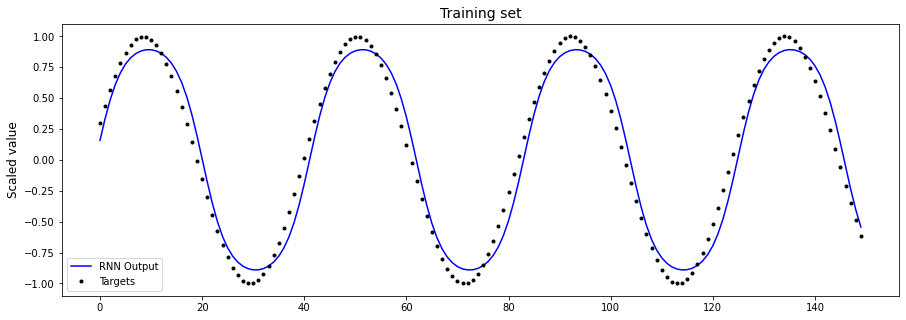

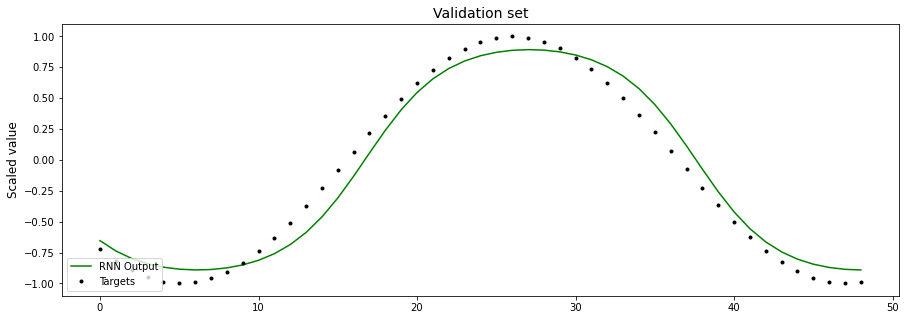

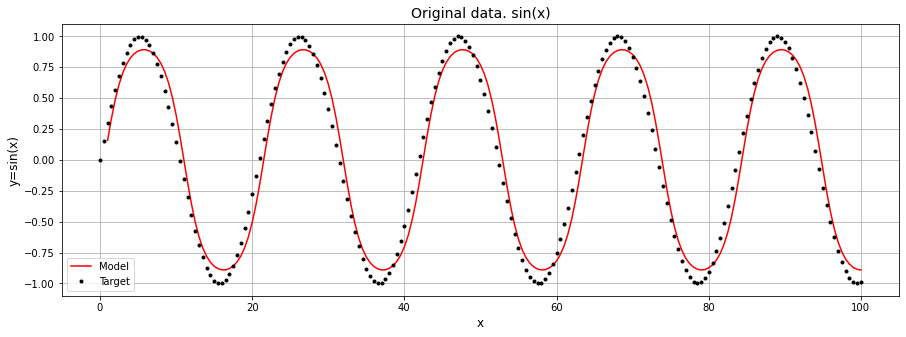

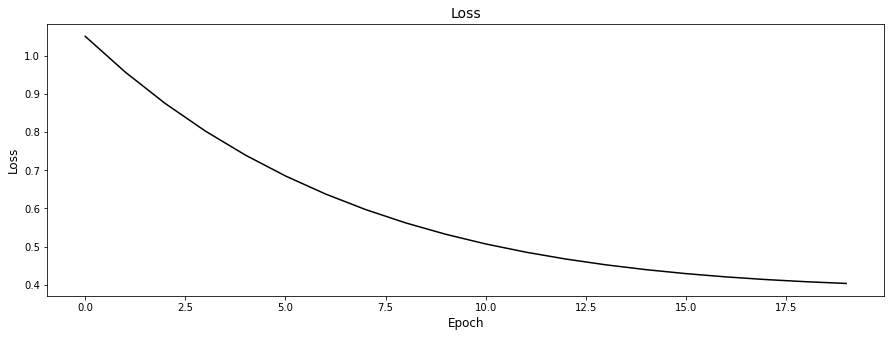

Test set MSE:  0.016308681432997848


In [8]:
#Example with the function sin(x)

#Initial values
output_size=1
rlayer_size=1
seq_len=2

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Sin.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(rlayer_size,output_size,321) #Define a seed for reproducibility

#Train the RNN
New_Param,test_loss,A=train(X,Y,Parameters,epochs=20,learning_rate=0.001,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower left') 
plt.show()

#Plot the test set using the scaled values 
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'g', label='RNN Output')
plt.plot(Y_test, '.k',label='Targets')
plt.title("Validation set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower left')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data. sin(x)", fontsize=14)
plt.ylabel('y=sin(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

The best parameters found for this RNN are stored in `New_Param`. If we would like to use this RNN to estimate a new value for the $sin(x)$ function considering the two previous values then we can use the following parameters to run a forward propagation of the network.

In [5]:
New_Param

{'Wx': array([[0.98326231]]),
 'bx': array([[-0.00613641]]),
 'Wr': array([[0.15201392]]),
 'Wy': array([[1.11527698]]),
 'by': array([[0.0035602]])}


**Keras:** we can try to build a RNN using the Keras library. One of the many advantages of this is that there is no need of creating functions or dealing with backprop. Keras will take care of all that. The only thing we need to do is to define the structure of the RNN, prepare the input data and then compiling and running the model. The RNNs built with Keras are not as simple as the Vanilla RNN we presented before so we can expect these models to run faster and deliver better results. This [page](https://www.tensorflow.org/guide/keras/rnn) contains an useful guide of how to configure a RNN using Keras.

In this case, we are going to run a model with one hidden layer and a sequence length of 2. This is the same architecture we used in the Vanilla RNN. Note how the activation functions and the number of units in each layer are also the same.

Epoch 1/20
150/150 [==============================] - 1s 954us/step - loss: 1.9568 - mean_squared_error: 1.9568
Epoch 2/20
150/150 [==============================] - 0s 792us/step - loss: 1.5125 - mean_squared_error: 1.5125
Epoch 3/20
150/150 [==============================] - 0s 809us/step - loss: 1.1598 - mean_squared_error: 1.1598
Epoch 4/20
150/150 [==============================] - 0s 810us/step - loss: 0.8841 - mean_squared_error: 0.8841
Epoch 5/20
150/150 [==============================] - 0s 790us/step - loss: 0.6867 - mean_squared_error: 0.6867
Epoch 6/20
150/150 [==============================] - 0s 799us/step - loss: 0.5661 - mean_squared_error: 0.5661
Epoch 7/20
150/150 [==============================] - 0s 791us/step - loss: 0.4952 - mean_squared_error: 0.4952
Epoch 8/20
150/150 [==============================] - 0s 785us/step - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 9/20
150/150 [==============================] - 0s 787us/step - loss: 0.3415 - mean_squared_error:

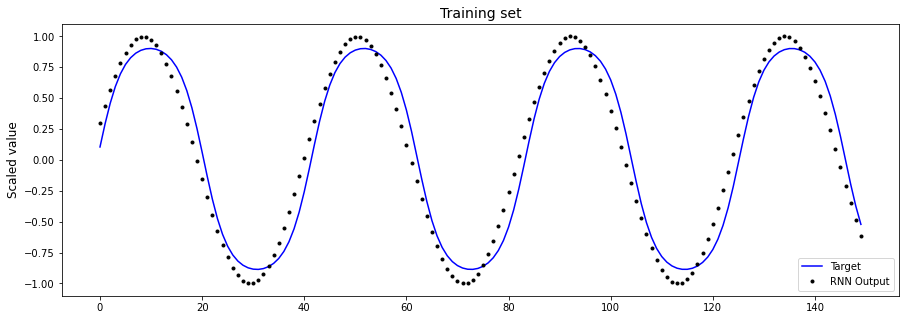

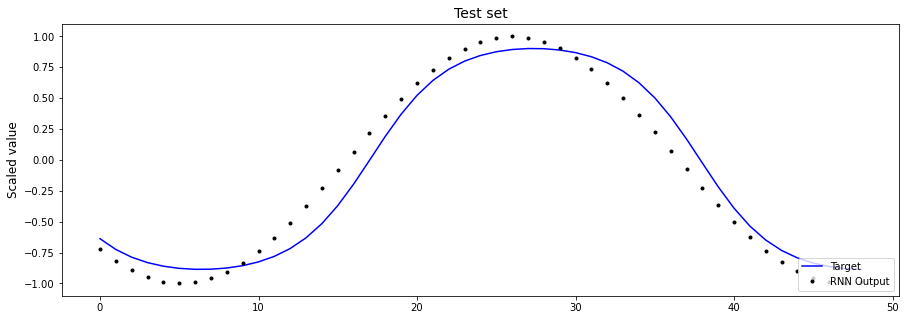

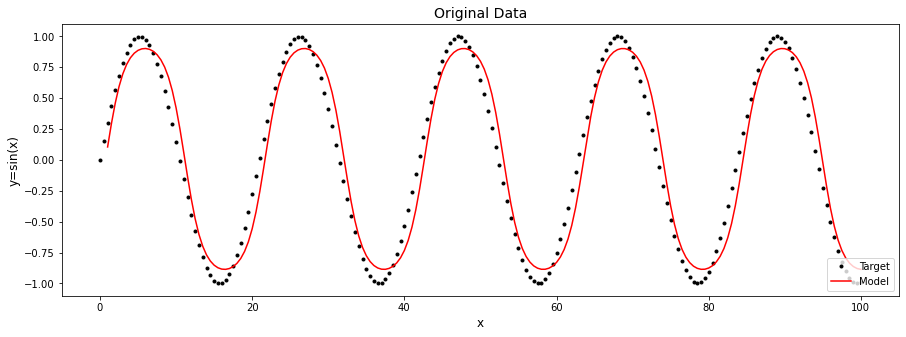

Test set MSE:  0.023824286383778537


In [12]:
output_size=1
rlayer_size=1
seq_len=2

#Define the structure
model = Sequential(name="RNN-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(SimpleRNN(units=rlayer_size, activation='tanh', name='Hidden_Recurrent_Layer')) # Hidden Recurrent Layer
model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('sin.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=20)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='Target')
plt.plot(Y, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='Target')
plt.plot(Y_test, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw2=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.plot(X_raw[seq_len:],Y_predicted_raw2,'r', label='Model')
plt.title("Original Data", fontsize=14)
plt.ylabel('y=sin(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.legend(loc='lower right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

We can get a summary of the weights and biases that were used in Keras

In [22]:
model.summary() # print model summary
print("")
print('This are the parameters associated with the Keras RNN')
##print("Note, the last parameter in each layer is bias while the rest are weights")
print("")
for layer in model.layers:
    print(layer.name)
    for item in layer.get_weights():
        print("  ", item)
print("Note that for the hidden recurrent layer, the first parameter corresponds to wx, the second one to wr and the third one is the bias")

Model: "RNN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Recurrent_Layer (Sim  (None, 1)                3         
 pleRNN)                                                         
                                                                 
 Output-Layer (Dense)        (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________

This are the parameters associated with the Keras RNN

Hidden_Recurrent_Layer
   [[-0.8984445]]
   [[-0.51259726]]
   [6.5763015e-05]
Output-Layer
   [[-2.0358326]]
   [-0.0055124]
Note that for the hidden recurrent layer, the first parameter corresponds to wx, the second one to wr and the third one is the bias


The results from the Vanilla RNN and Keras are similar. After the plots you will find the Mean Squared Error (MSE) calculated with the test set. Note how the numbers are really close and a visual inspection of the plots also shows that both RNNs are matching most of the points.

**Multi-layer Perceptron Regressor:** as a third and final test for this function, we can try to use a [Multi-layer Perceptron (MLP)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) from the sklearn library. The MLP can be used as a classifier or a regressor. Since this time our target data is not made by categories or integers we will use the regressor. Similar to the example with Keras, it is important to mention here that the main advantage of using a library is that we do not need to create any function or write the equations for the backprop. In this case, we only need to define the structure of the ANN and the activation function in its hidden layers.

To get a good result we are using 3 hidden layers with 25, 15 and 5 units respectively. You can try different combinations but you may find that is hard to train this function using only one hidden layer as we did in the RNNs. Another important thing to note is that the separation of train and test datasets is different from the previous one. This time, instead of selecting the **last points** that represented the 25% (or any other ratio) of the total population of points, we are randomly selecting 25% of the points. This is due to the way in which the ANNs work in comparison to RNNs. We are not training a network to learn from a sequence of points this time. We are training it to get the value of a variable ( $sin(x)$ ) from another one ($x$).

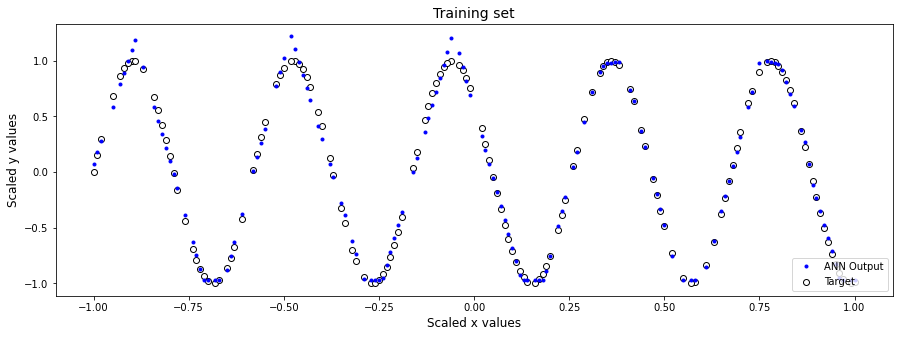

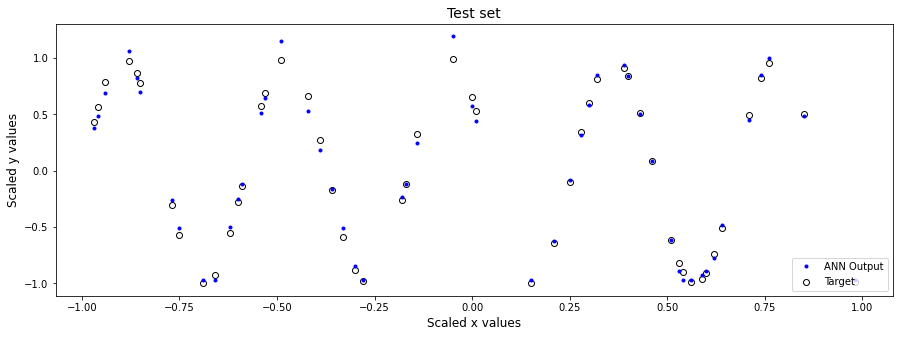

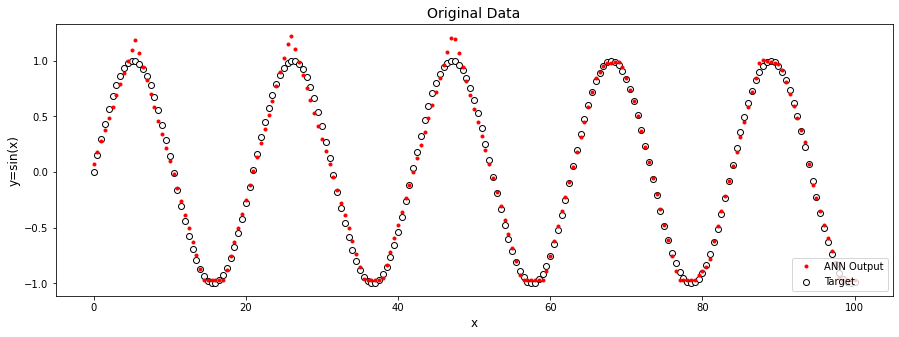

Test set MSE:  0.962438394651183


In [58]:
#Prepare and Scale Data
Raw_Data=pd.read_csv('sin.csv')
Raw_Data=Raw_Data.to_numpy()
X_raw=Raw_Data[:,0]
Y_raw=Raw_Data[:,1]
X_raw=X_raw.reshape(-1,1)

Scaler1=MinMaxScaler((-1,1)).fit(X_raw)
X_raw=Scaler1.transform(X_raw.reshape(-1, 1))
Scaler2=MinMaxScaler((-1,1)).fit(Y_raw.reshape(-1, 1))
Y_raw=Scaler2.transform(Y_raw.reshape(-1, 1))
Y_raw=Y_raw.reshape(-1,)

#Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_raw,Y_raw,random_state=3,shuffle=True)

#Build and train MLP
regr = MLPRegressor(hidden_layer_sizes=[25,15,5], activation='relu', 
                    solver='lbfgs', random_state=197, max_iter=2000).fit(X_train, y_train)
y_mod_train=regr.predict(X_train)
y_mod_test=regr.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_train,y_train, edgecolor='k', c='white', label='Target')
plt.plot(X_train,y_mod_train, '.b', label='ANN Output')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_test,y_test, edgecolor='k', c='white', label='Target')
plt.plot(X_test,y_mod_test, '.b', label='ANN Output')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Apply an inverse scale to plot everything on its original form
y_train_raw=Scaler2.inverse_transform(y_mod_train.reshape(-1,1))
y_test_raw=Scaler2.inverse_transform(y_mod_test.reshape(-1,1))
y_train_raw=y_train_raw.reshape(-1)
y_test_raw=y_test_raw.reshape(-1)
y_pred_raw=np.concatenate((y_train_raw,y_test_raw))
Y_raw=Scaler2.inverse_transform(Y_raw.reshape(-1,1))

X_train_raw=Scaler1.inverse_transform(X_train.reshape(-1,1))
X_test_raw=Scaler1.inverse_transform(X_test.reshape(-1,1))
X_train_raw=X_train_raw.reshape(-1)
X_test_raw=X_test_raw.reshape(-1)
X_pred_raw=np.concatenate((X_train_raw,X_test_raw))
X_raw=Scaler1.inverse_transform(X_raw.reshape(-1,1))

#Plot the original data
plt.figure(figsize=(15,5))
plt.scatter(X_raw,Y_raw, edgecolor='k', c='white', label='Target')
plt.plot(X_pred_raw, y_pred_raw, '.r', label='ANN Output')
plt.title("Original Data", fontsize=14)
plt.ylabel('y=sin(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.legend(loc='lower right')
plt.show()


print("Test set MSE: ", mean_squared_error(X_test,y_test))


### Example 2: Oil production

As a second example, we can take the monthly oil production from an oil well and try to train a RNN to reproduce its behaviour. This example is more complicated than the last one because these data does not follow a pattern like the $sin(x)$ function. Instead, it changes drastically with time. As it was done in the previous case, we will work with three cases: a Vanilla RNN, Keras and a MLP.

**Vanilla RNN:** We will use the same functions we defined before. However, this time, we will use a sequence length of 15. This means that the RNN will be trained to read 15 values and then calculate the 16th value. We will still use one hidden layer in this case.

Epoch: 1, Loss: [[27.13077194]], Validation Loss: [[22.10875816]]
Epoch: 2, Loss: [[22.83824125]], Validation Loss: [[15.67631265]]
Epoch: 3, Loss: [[21.61566567]], Validation Loss: [[12.34336156]]
Epoch: 4, Loss: [[21.22225383]], Validation Loss: [[10.49330034]]
Epoch: 5, Loss: [[20.98285859]], Validation Loss: [[9.38821682]]
Epoch: 6, Loss: [[20.72550598]], Validation Loss: [[8.67313686]]
Epoch: 7, Loss: [[20.42584235]], Validation Loss: [[8.16925545]]
Epoch: 8, Loss: [[20.09513944]], Validation Loss: [[7.7833286]]
Epoch: 9, Loss: [[19.74837904]], Validation Loss: [[7.46560568]]
Epoch: 10, Loss: [[19.39703333]], Validation Loss: [[7.18918267]]
Epoch: 11, Loss: [[19.04866312]], Validation Loss: [[6.93940506]]
Epoch: 12, Loss: [[18.70793632]], Validation Loss: [[6.70825691]]
Epoch: 13, Loss: [[18.37762724]], Validation Loss: [[6.49133266]]
Epoch: 14, Loss: [[18.05932827]], Validation Loss: [[6.28618645]]
Epoch: 15, Loss: [[17.75390511]], Validation Loss: [[6.09142881]]
Epoch: 16, Loss:

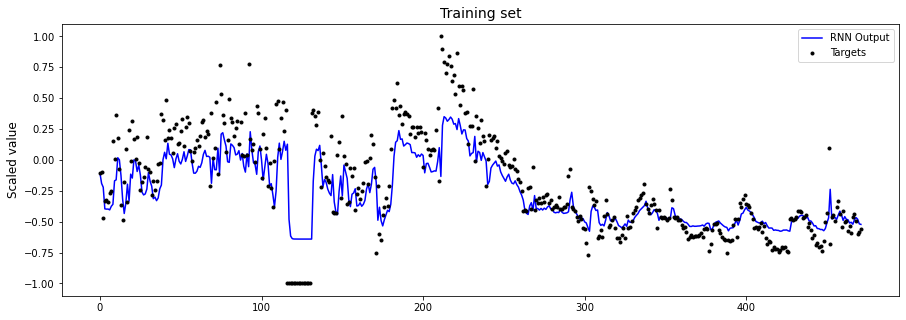

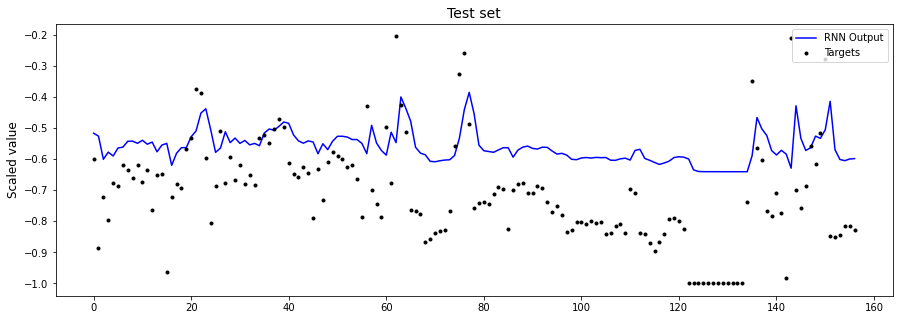

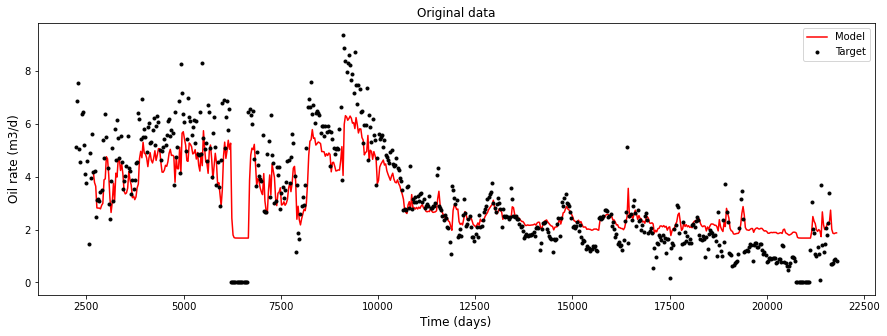

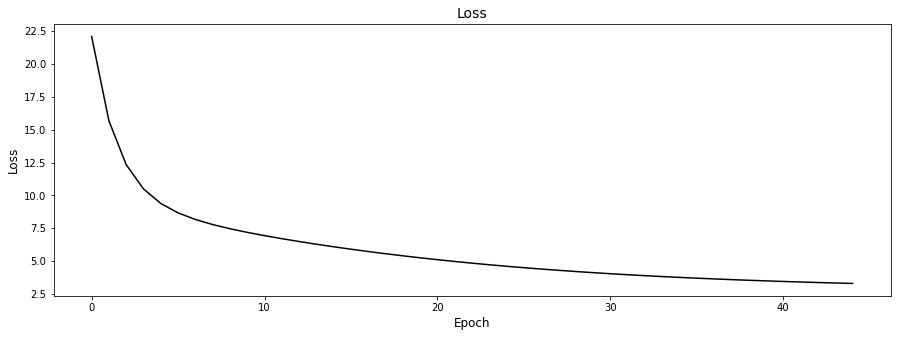

Test set MSE:  0.04163087885322605


In [8]:

output_size=1
rlayer_size=1
seq_len=15

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(rlayer_size,output_size,100) #Define a seed for reproducibility

#Train the RNN
New_Param,test_loss,A=train(X,Y,Parameters,epochs=45,learning_rate=0.001,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Plot the test set using the scaled values
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_test, 'b', label='RNN Output')
plt.plot(Y_test, '.k', label='Targets')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data
plt.figure(figsize=(15, 5))
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.title("Original data")
plt.legend(loc='upper right')
plt.show()


#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

As we did before we can extract the parameters that were used to train this RNN. They are stored in the variable `New_Param`. Note how the RNN's behaviour is not ideal towards the final period of data where the test dataset is.

In [4]:
New_Param

{'Wx': array([[0.75167522]]),
 'bx': array([[-0.04306637]]),
 'Wr': array([[0.4168468]]),
 'Wy': array([[0.65207395]]),
 'by': array([[-0.11125634]])}

Now, let's try to run the Vanilla RNN again but this time using a shorter sequence length of 2 and 2 units in the hidden layer

Epoch: 1, Loss: [[10.13450152]], Validation Loss: [[1.67545151]]
Epoch: 2, Loss: [[10.1567372]], Validation Loss: [[1.57055256]]
Epoch: 3, Loss: [[10.2389687]], Validation Loss: [[1.4945521]]
Epoch: 4, Loss: [[10.36462568]], Validation Loss: [[1.4414748]]
Epoch: 5, Loss: [[10.52068693]], Validation Loss: [[1.40651121]]
Epoch: 6, Loss: [[10.69698495]], Validation Loss: [[1.38579325]]
Epoch: 7, Loss: [[10.88564176]], Validation Loss: [[1.3762133]]
The training loss is: [[11.0806115]] and the validation loss is: [[1.37527832]]
The training MSE is: 0.046169214588061044 and the test MSE is: 0.01729909833392387


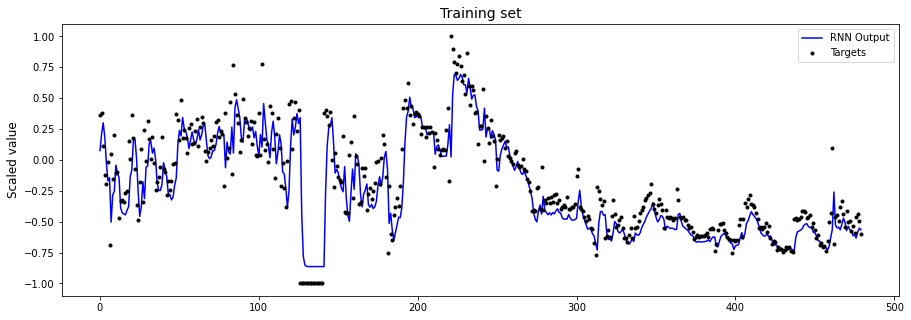

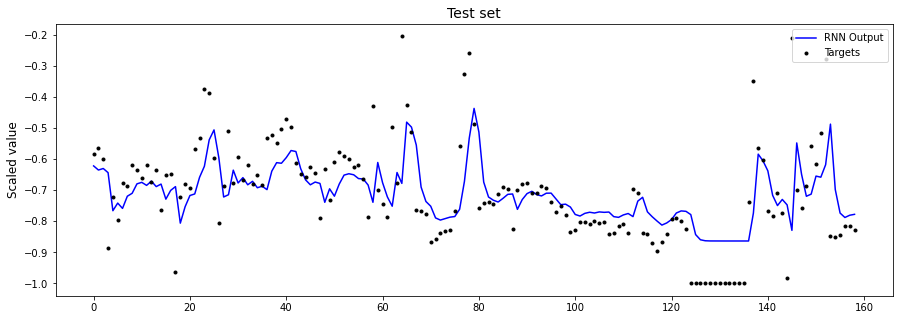

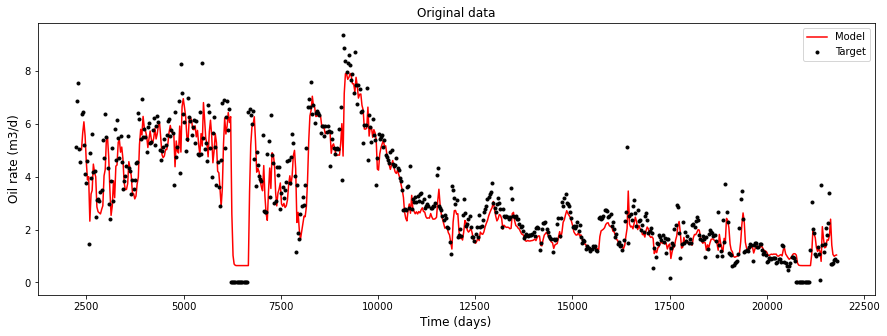

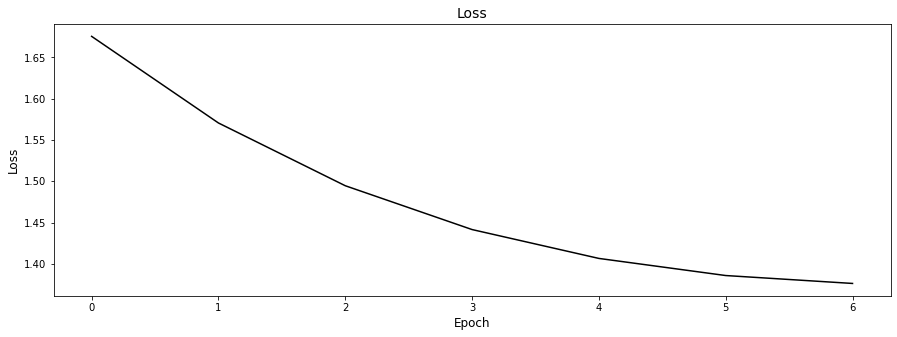

Test set MSE:  0.01729909833392387


In [5]:
#Initial values
output_size=1
rlayer_size=2
seq_len=5 

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(rlayer_size,output_size,100) #Define a seed for reproducibility

#Train the RNN
New_Param,test_loss,A=train(X,Y,Parameters,epochs=7,learning_rate=0.0001,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Plot the test set using the scaled values
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_test, 'b', label='RNN Output')
plt.plot(Y_test, '.k', label='Targets')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data
plt.figure(figsize=(15, 5))
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.title("Original data")
plt.legend(loc='upper right')
plt.show()


#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

Note how, the test MSE in this case is slightly lower than the previous case. In terms of the parameters this case is different because we have two hidden layers. This means that this RNN will have:
- 6 weights and 2 biases in the hidden layer
- 2 weights and 1 bias in the output layer

In [6]:
New_Param

{'Wx': array([[0.54883514],
        [0.28555982]]),
 'bx': array([[-0.01276086],
        [-0.01648274]]),
 'Wr': array([[0.42746122, 0.84639536],
        [0.00861385, 0.12371011]]),
 'Wy': array([[0.67559969, 0.82851827]]),
 'by': array([[-0.02033374]])}

**Keras:** we can build a Keras RNN using the same architecture we followed in the first Vanilla RNN example. This is how a Keras RNN with one hidden layer and a sequence length of 15 would look like:

Epoch 1/20
472/472 [==============================] - 4s 7ms/step - loss: 0.1085 - mean_squared_error: 0.1085
Epoch 2/20
472/472 [==============================] - 3s 7ms/step - loss: 0.0879 - mean_squared_error: 0.0879
Epoch 3/20
472/472 [==============================] - 3s 7ms/step - loss: 0.0743 - mean_squared_error: 0.0743
Epoch 4/20
472/472 [==============================] - 3s 5ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 5/20
472/472 [==============================] - 2s 5ms/step - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 6/20
472/472 [==============================] - 3s 5ms/step - loss: 0.0514 - mean_squared_error: 0.0514
Epoch 7/20
472/472 [==============================] - 3s 6ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8/20
472/472 [==============================] - 3s 7ms/step - loss: 0.0463 - mean_squared_error: 0.0463
Epoch 9/20
472/472 [==============================] - 3s 6ms/step - loss: 0.0448 - mean_squared_error: 0.0448
Epoch 10/2

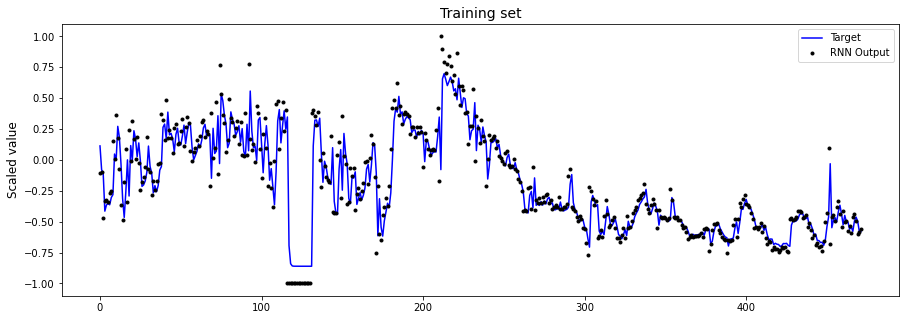

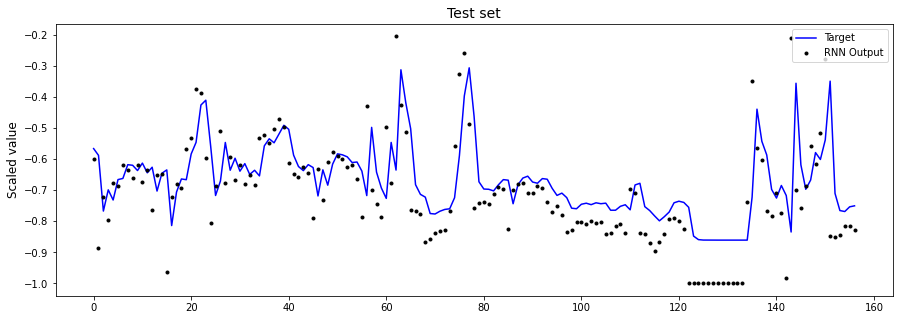

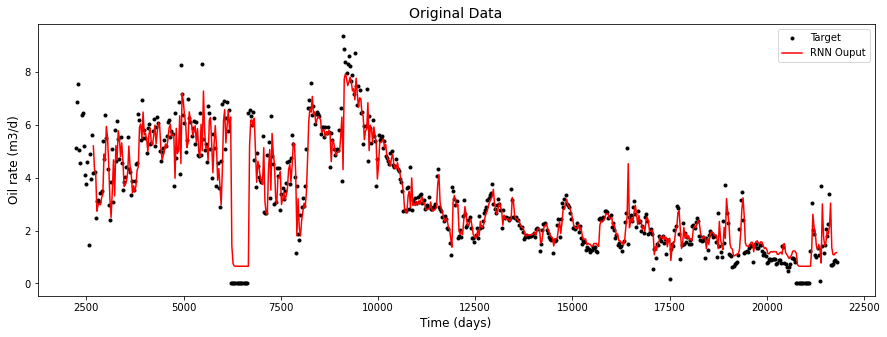

Test set MSE:  0.0191939218117742


In [7]:
output_size=1
rlayer_size=1
seq_len=15

#Define the structure
model = Sequential(name="RNN-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(SimpleRNN(units=rlayer_size, activation='tanh', name='Hidden_Recurrent_Layer')) # Hidden Recurrent Layer
model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=20)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='Target')
plt.plot(Y, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='Target')
plt.plot(Y_test, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='RNN Ouput')
plt.title("Original Data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)', fontsize=12)
plt.legend(loc='upper right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

Now let's try to adjust the oil rate data with a MLP Regressor. Remember that this time, the separation between training and test data is done differently and that the MLP will be trained to reproduce the oil rate taking into account the days and not previous values of oil rate.

**Multi Layer Perceptron Regressor**

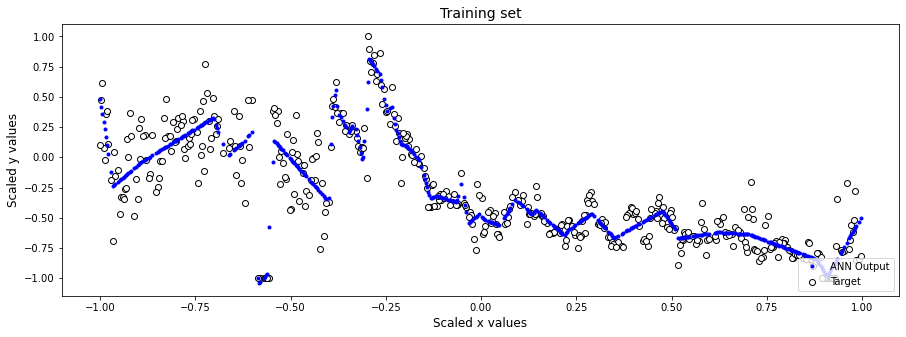

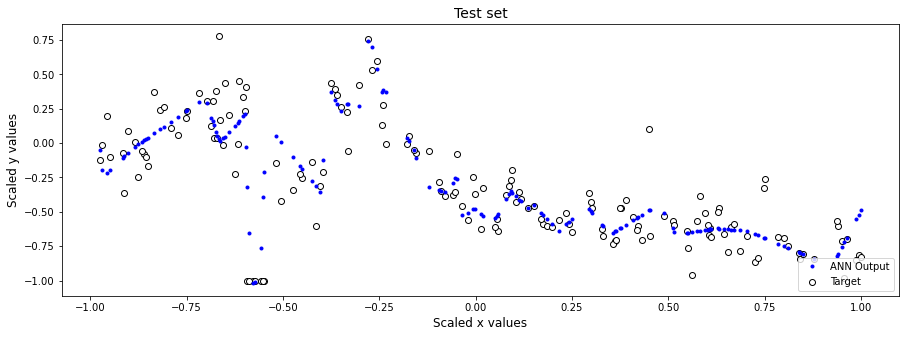

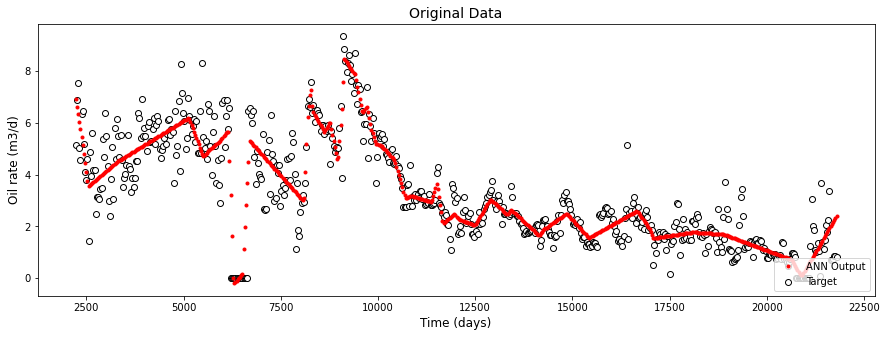

Test set MSE:  0.9033149376181921


In [8]:
#Prepare and Scale Data
Raw_Data=pd.read_csv('Declination3.csv')
Raw_Data=Raw_Data.to_numpy()
X_raw=Raw_Data[:,0]
Y_raw=Raw_Data[:,1]
X_raw=X_raw.reshape(-1,1)

Scaler1=MinMaxScaler((-1,1)).fit(X_raw)
X_raw=Scaler1.transform(X_raw.reshape(-1, 1))
Scaler2=MinMaxScaler((-1,1)).fit(Y_raw.reshape(-1, 1))
Y_raw=Scaler2.transform(Y_raw.reshape(-1, 1))
Y_raw=Y_raw.reshape(-1,)

#Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_raw,Y_raw,random_state=3,shuffle=True)

#Build and train MLP
regr = MLPRegressor(hidden_layer_sizes=[100,50,25], activation='relu', 
                    solver='lbfgs', random_state=197, max_iter=2000).fit(X_train, y_train)
y_mod_train=regr.predict(X_train)
y_mod_test=regr.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_train,y_train, edgecolor='k', c='white', label='Target')
plt.plot(X_train,y_mod_train, '.b', label='ANN Output')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_test,y_test, edgecolor='k', c='white', label='Target')
plt.plot(X_test,y_mod_test, '.b', label='ANN Output')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Apply an inverse scale to plot everything on its original form
y_train_raw=Scaler2.inverse_transform(y_mod_train.reshape(-1,1))
y_test_raw=Scaler2.inverse_transform(y_mod_test.reshape(-1,1))
y_train_raw=y_train_raw.reshape(-1)
y_test_raw=y_test_raw.reshape(-1)
y_pred_raw=np.concatenate((y_train_raw,y_test_raw))
Y_raw=Scaler2.inverse_transform(Y_raw.reshape(-1,1))

X_train_raw=Scaler1.inverse_transform(X_train.reshape(-1,1))
X_test_raw=Scaler1.inverse_transform(X_test.reshape(-1,1))
X_train_raw=X_train_raw.reshape(-1)
X_test_raw=X_test_raw.reshape(-1)
X_pred_raw=np.concatenate((X_train_raw,X_test_raw))
X_raw=Scaler1.inverse_transform(X_raw.reshape(-1,1))

#Plot the original data
plt.figure(figsize=(15,5))
plt.scatter(X_raw,Y_raw, edgecolor='k', c='white', label='Target')
plt.plot(X_pred_raw, y_pred_raw, '.r', label='ANN Output')
plt.title("Original Data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)', fontsize=12)
plt.legend(loc='lower right')
plt.show()


print("Test set MSE: ", mean_squared_error(X_test,y_test))


It is important to observe how the MLP matches the general behaviour of the data. However, it fails to reproduce the small bumps and reductions that are always present. The MLP does a good work as an estimator of a general trend but it is not very useful to predict a single value at a particular point in time.

### Stock history 

As a final example we will use the behaviour of the [Vanguard Total Stock Market Index Fund ETF (VTI)](https://finance.yahoo.com/quote/VTI/). The dataset consists of the daily closing value for the period that goes from Aug 23, 2012 to Aug 23, 2022.


**Vanilla RNN**: for this case let's try first with a RNN that contains one hidden layer and a sequence length of 3

Epoch: 1, Loss: [[49.17177841]], Validation Loss: [[22.27825333]]
Epoch: 2, Loss: [[17.6699197]], Validation Loss: [[22.32421627]]
Epoch: 3, Loss: [[12.57202124]], Validation Loss: [[17.00241382]]
Epoch: 4, Loss: [[8.82865841]], Validation Loss: [[12.78014401]]
Epoch: 5, Loss: [[6.01300923]], Validation Loss: [[9.60864163]]
Epoch: 6, Loss: [[4.00534187]], Validation Loss: [[7.28195259]]
Epoch: 7, Loss: [[2.66359538]], Validation Loss: [[5.60913087]]
Epoch: 8, Loss: [[1.84047854]], Validation Loss: [[4.42758698]]
Epoch: 9, Loss: [[1.39997842]], Validation Loss: [[3.60608091]]
Epoch: 10, Loss: [[1.22649073]], Validation Loss: [[3.04293332]]
Epoch: 11, Loss: [[1.22793068]], Validation Loss: [[2.66187962]]
Epoch: 12, Loss: [[1.33485631]], Validation Loss: [[2.40719596]]
Epoch: 13, Loss: [[1.49745105]], Validation Loss: [[2.23903747]]
Epoch: 14, Loss: [[1.68171776]], Validation Loss: [[2.1294289]]
Epoch: 15, Loss: [[1.86572014]], Validation Loss: [[2.05903732]]
Epoch: 16, Loss: [[2.03629839

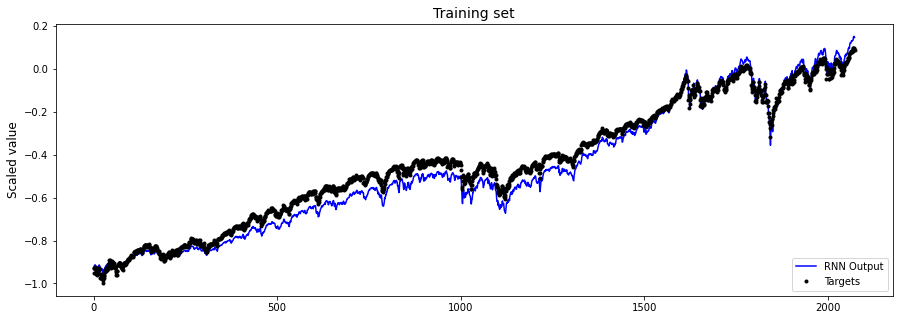

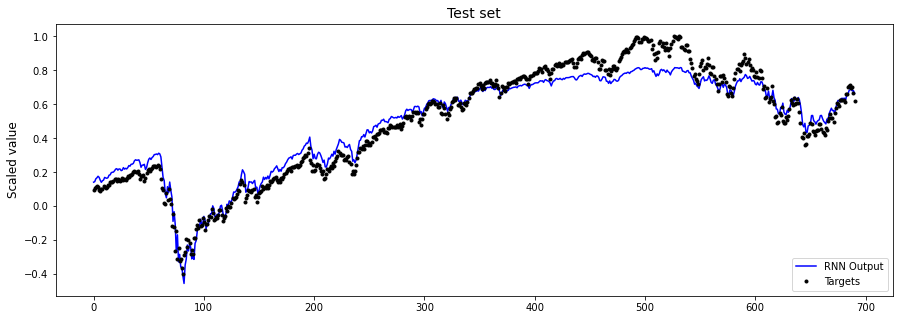

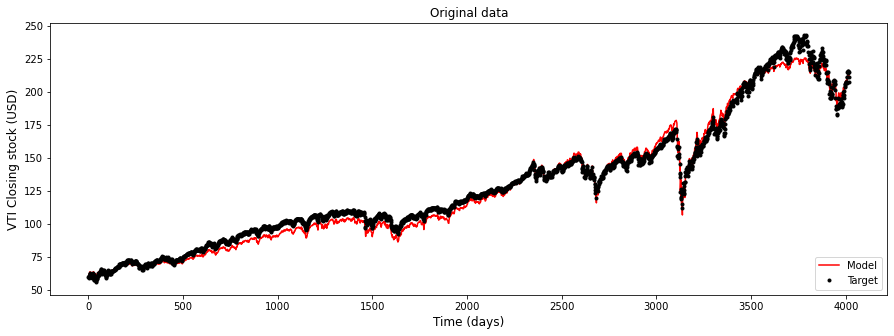

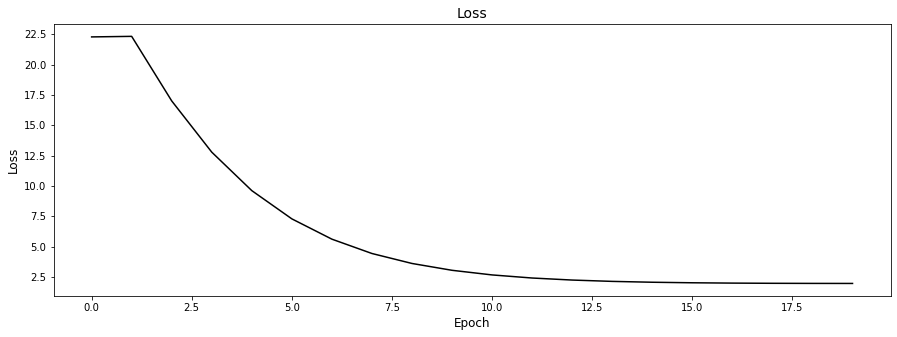

Test set MSE:  0.005671848470953825


In [3]:
#Initial values
output_size=1
rlayer_size=1
seq_len=3 

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('VTI.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(rlayer_size,output_size,335) #Define a seed for reproducibility

#Train the RNN
New_Param,test_loss,A=train(X,Y,Parameters,epochs=20,learning_rate=0.001,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Plot the test set using the scaled values
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_test, 'b', label='RNN Output')
plt.plot(Y_test, '.k', label='Targets')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data
plt.figure(figsize=(15, 5))
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data", fontsize=14)
plt.ylabel('VTI Closing stock (USD)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.title("Original data")
plt.legend(loc='lower right')
plt.show()


#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

Results seem to be close to the real data. We can also try to keep the same number of units in the hidden layer and to increase the sequence lenght

Epoch: 1, Loss: [[48.08287706]], Validation Loss: [[22.27524707]]
Epoch: 2, Loss: [[18.32701491]], Validation Loss: [[22.02199465]]
Epoch: 3, Loss: [[13.2969538]], Validation Loss: [[16.8431137]]
Epoch: 4, Loss: [[9.5460628]], Validation Loss: [[12.72096345]]
Epoch: 5, Loss: [[6.66117457]], Validation Loss: [[9.60990513]]
Epoch: 6, Loss: [[4.54029592]], Validation Loss: [[7.31641225]]
Epoch: 7, Loss: [[3.05974468]], Validation Loss: [[5.65975125]]
Epoch: 8, Loss: [[2.08811071]], Validation Loss: [[4.48475309]]
Epoch: 9, Loss: [[1.50138474]], Validation Loss: [[3.66506334]]
Epoch: 10, Loss: [[1.19191633]], Validation Loss: [[3.1019155]]
Epoch: 11, Loss: [[1.07207403]], Validation Loss: [[2.72058518]]
Epoch: 12, Loss: [[1.074212]], Validation Loss: [[2.46602256]]
Epoch: 13, Loss: [[1.14850426]], Validation Loss: [[2.29856341]]
Epoch: 14, Loss: [[1.25985359]], Validation Loss: [[2.19016768]]
Epoch: 15, Loss: [[1.38466533]], Validation Loss: [[2.12134255]]
Epoch: 16, Loss: [[1.50792339]], 

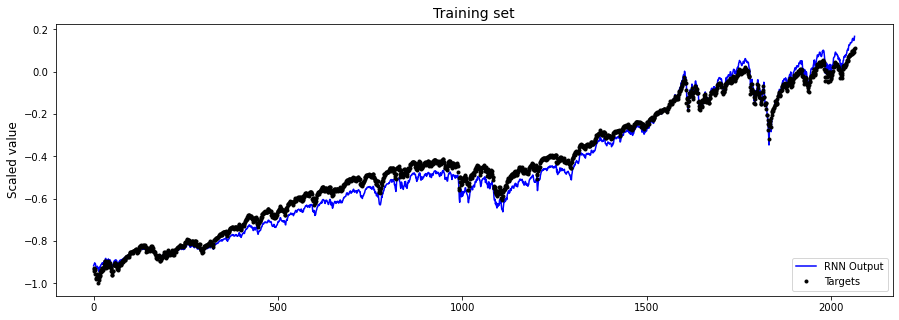

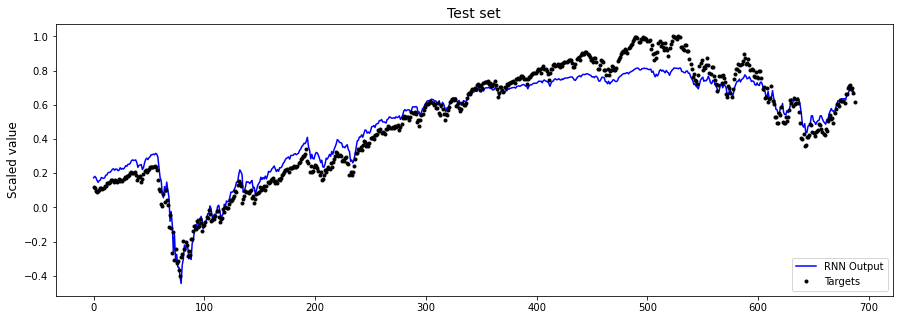

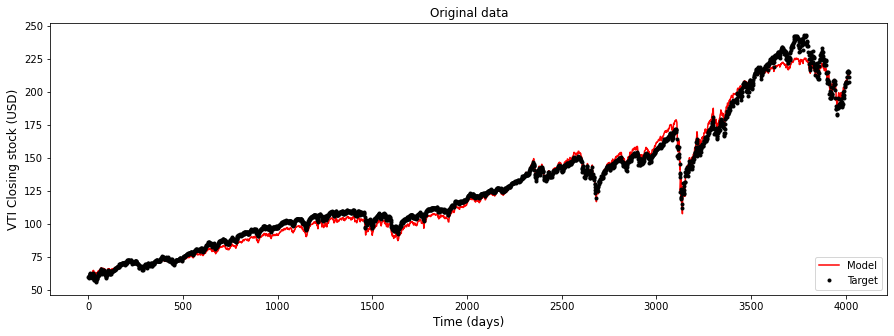

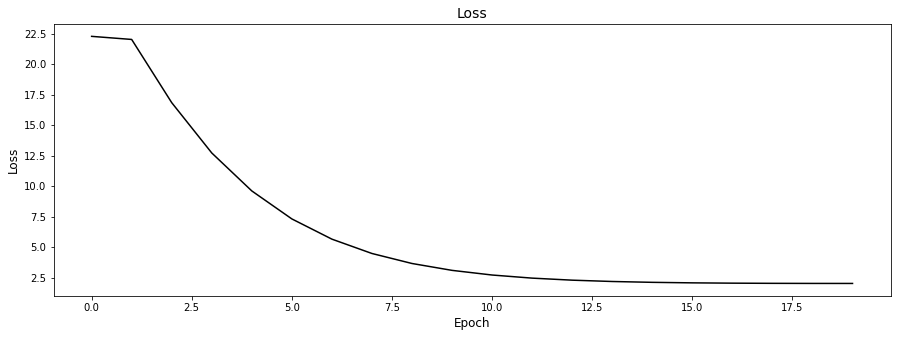

Test set MSE:  0.0059050736438430755


In [4]:
#Initial values
output_size=1
rlayer_size=1
seq_len=15 

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('VTI.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(rlayer_size,output_size,335)

#Train the RNN
New_Param,test_loss,A=train(X,Y,Parameters,epochs=20,learning_rate=0.001,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Plot the test set using the scaled values
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_test, 'b', label='RNN Output')
plt.plot(Y_test, '.k', label='Targets')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data
plt.figure(figsize=(15, 5))
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data", fontsize=14)
plt.ylabel('VTI Closing stock (USD)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.title("Original data")
plt.legend(loc='lower right')
plt.show()


#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

Results are similar to the previous example. Remember that the difference is that, this time, we are training the RNN to take 15 values and calculate the 16th value. For all cases, the 16th value is calculated with this combination of parameters:

In [5]:
New_Param

{'Wx': array([[0.95121674]]),
 'bx': array([[0.11953713]]),
 'Wr': array([[0.15053274]]),
 'Wy': array([[1.1212159]]),
 'by': array([[-0.11770019]])}

**Keras**: as we have done previously, let's build a similar case with Keras

Epoch 1/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.1989 - mean_squared_error: 0.1989
Epoch 2/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 6/10
2065/2065 [==============================] - 3s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 7/10
2065/2065 [==============================] - 3s 1ms/step - loss: 8.0655e-04 - mean_squared_error: 8.0655e-04
Epoch 8/10
2065/2065 [==============================] - 3s 1ms/step - loss: 2.4777e-04 - mean_squared_error: 2.4777e-04
Epoch 9/10
2065/2065 [==============================] - 3s 1ms/step - loss: 1.6836e-04 -

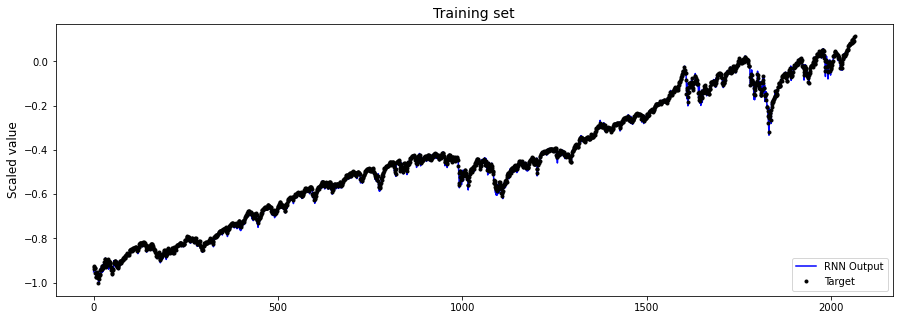

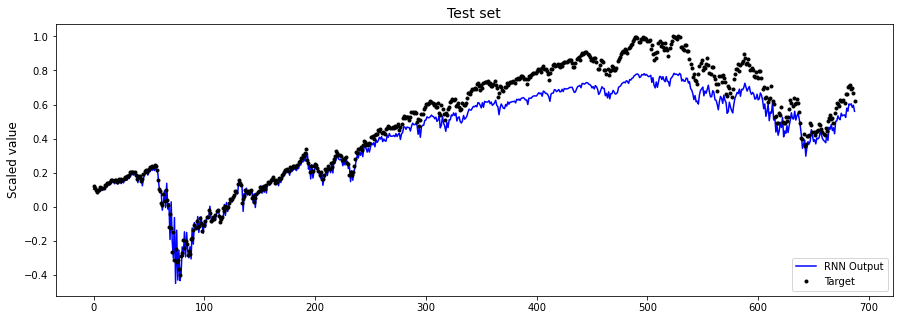

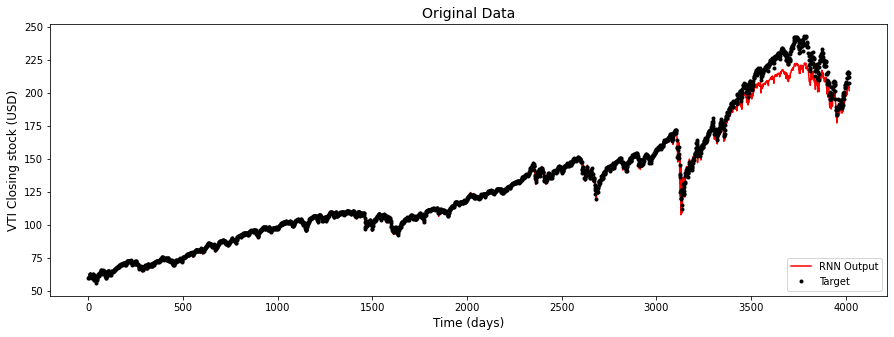

Test set MSE:  0.011421186787186954


In [6]:
output_size=1
rlayer_size=1
seq_len=15

#Define the structure
model = Sequential(name="RNN-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(SimpleRNN(units=rlayer_size, activation='tanh', name='Hidden_Recurrent_Layer')) # Hidden Recurrent Layer
model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('VTI.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=10)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='RNN Output')
plt.plot(Y, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='RNN Output')
plt.plot(Y_test, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='RNN Output')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original Data", fontsize=14)
plt.ylabel('VTI Closing stock (USD)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.legend(loc='lower right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

**Multi-layer Perceptron:** finally, we can try to train a MLP with the data from the VTI stock. As we saw previously, the MLP does a good job learning the general trend of the data but it is not very precise when its outputs are compared to the real targets. In addition to this, it needs to train more parameters.

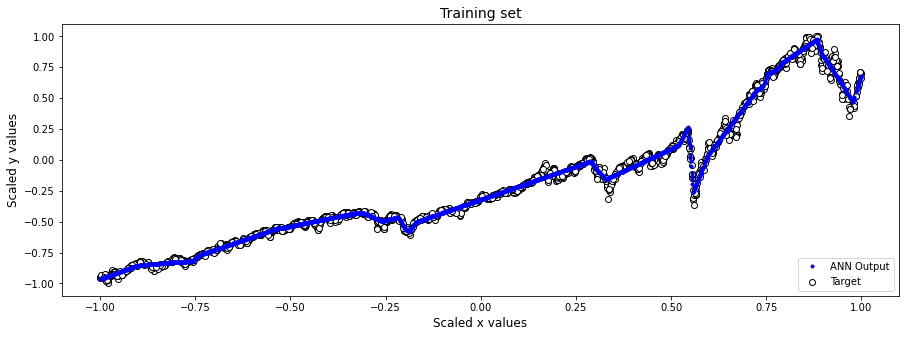

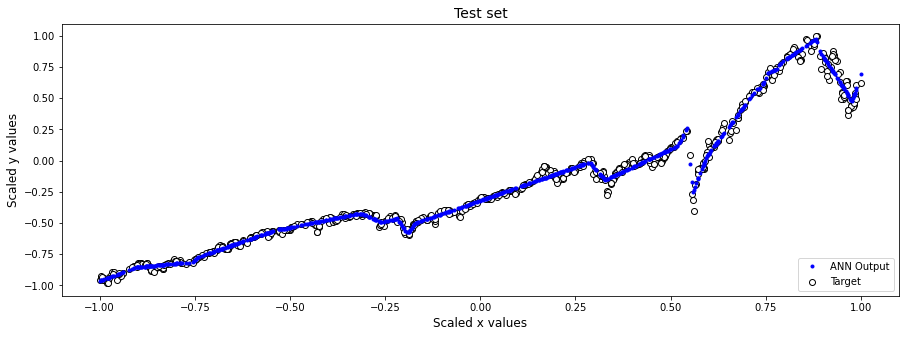

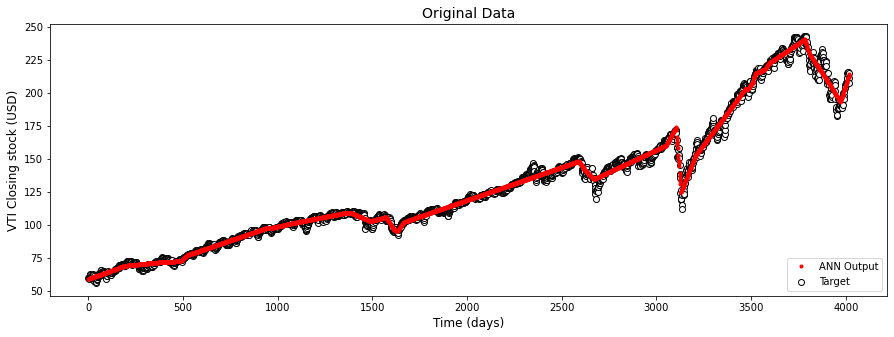

Test set MSE:  0.08489315583209867


In [7]:
#Prepare and Scale Data
Raw_Data=pd.read_csv('VTI.csv')
Raw_Data=Raw_Data.to_numpy()
X_raw=Raw_Data[:,0]
Y_raw=Raw_Data[:,1]
X_raw=X_raw.reshape(-1,1)

Scaler1=MinMaxScaler((-1,1)).fit(X_raw)
X_raw=Scaler1.transform(X_raw.reshape(-1, 1))
Scaler2=MinMaxScaler((-1,1)).fit(Y_raw.reshape(-1, 1))
Y_raw=Scaler2.transform(Y_raw.reshape(-1, 1))
Y_raw=Y_raw.reshape(-1,)

#Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_raw,Y_raw,shuffle=True, random_state=5)

#Build and train MLP
regr = MLPRegressor(hidden_layer_sizes=[100,50], activation='relu', 
                    solver='lbfgs', random_state=111, max_iter=2000).fit(X_train, y_train)
y_mod_train=regr.predict(X_train)
y_mod_test=regr.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_train,y_train, edgecolor='k', c='white', label='Target')
plt.plot(X_train,y_mod_train, '.b', label='ANN Output')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15,5))
plt.scatter(X_test,y_test, edgecolor='k', c='white', label='Target')
plt.plot(X_test,y_mod_test, '.b', label='ANN Output')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled y values', fontsize=12)
plt.xlabel('Scaled x values', fontsize=12)
plt.legend(loc='lower right')
plt.show()

#Apply an inverse scale to plot everything on its original form
y_train_raw=Scaler2.inverse_transform(y_mod_train.reshape(-1,1))
y_test_raw=Scaler2.inverse_transform(y_mod_test.reshape(-1,1))
y_train_raw=y_train_raw.reshape(-1)
y_test_raw=y_test_raw.reshape(-1)
y_pred_raw=np.concatenate((y_train_raw,y_test_raw))
Y_raw=Scaler2.inverse_transform(Y_raw.reshape(-1,1))

X_train_raw=Scaler1.inverse_transform(X_train.reshape(-1,1))
X_test_raw=Scaler1.inverse_transform(X_test.reshape(-1,1))
X_train_raw=X_train_raw.reshape(-1)
X_test_raw=X_test_raw.reshape(-1)
X_pred_raw=np.concatenate((X_train_raw,X_test_raw))
X_raw=Scaler1.inverse_transform(X_raw.reshape(-1,1))

#Plot the original data
plt.figure(figsize=(15,5))
plt.scatter(X_raw,Y_raw, edgecolor='k', c='white', label='Target')
plt.plot(X_pred_raw, y_pred_raw, '.r', label='ANN Output')
plt.title("Original Data", fontsize=14)
plt.ylabel('VTI Closing stock (USD)', fontsize=12)
plt.xlabel('Time (days)', fontsize=12)
plt.legend(loc='lower right')
plt.show()


print("Test set MSE: ", mean_squared_error(X_test,y_test))


# Conclusion
This notebook contains a simple application of RNNs. The functions presented here are definitely not as robust and trustable the RNNs included in libraries such as Keras. However, it serves the purpose of understanding how a RNN works and why sometimes they also fail. You are encoraged to read [this article](https://medium.com/p/cd0b0a41fe75) that contains a more theoric approach to the topic of RNNs.